In [14]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fft import fft, ifft
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

import pmdarima.arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose


import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import optuna

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}",)

Using cuda


### Prepare time series

In [3]:
df = pd.read_csv('../data/paris_temperature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df['datetime'])
temp = df['temp']
temp.head(10)

datetime
2023-10-01    18.9
2023-10-02    20.7
2023-10-03    18.8
2023-10-04    14.2
2023-10-05    14.7
2023-10-06    14.7
2023-10-07    16.7
2023-10-08    18.5
2023-10-09    18.9
2023-10-10    18.9
Name: temp, dtype: float64

### Analysis

In [43]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts):
    adf_result = adfuller(ts)

    # Output the results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
        
    if adf_result[1] < 0.05:
        print("Time series is stationary.")
    else:
        print("Time series is non-stationary.")

adf_test(temp)

ADF Statistic: -2.742622887630039
p-value: 0.06694856335880962
Time series is non-stationary.


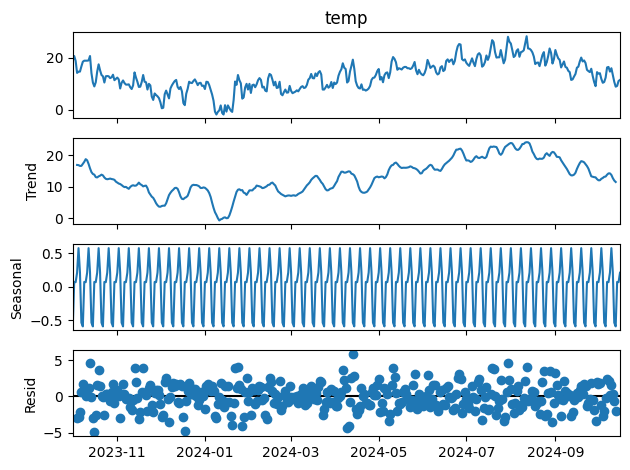

In [44]:
res_temp = seasonal_decompose(temp, model='additive')

res_temp.plot()
plt.show()

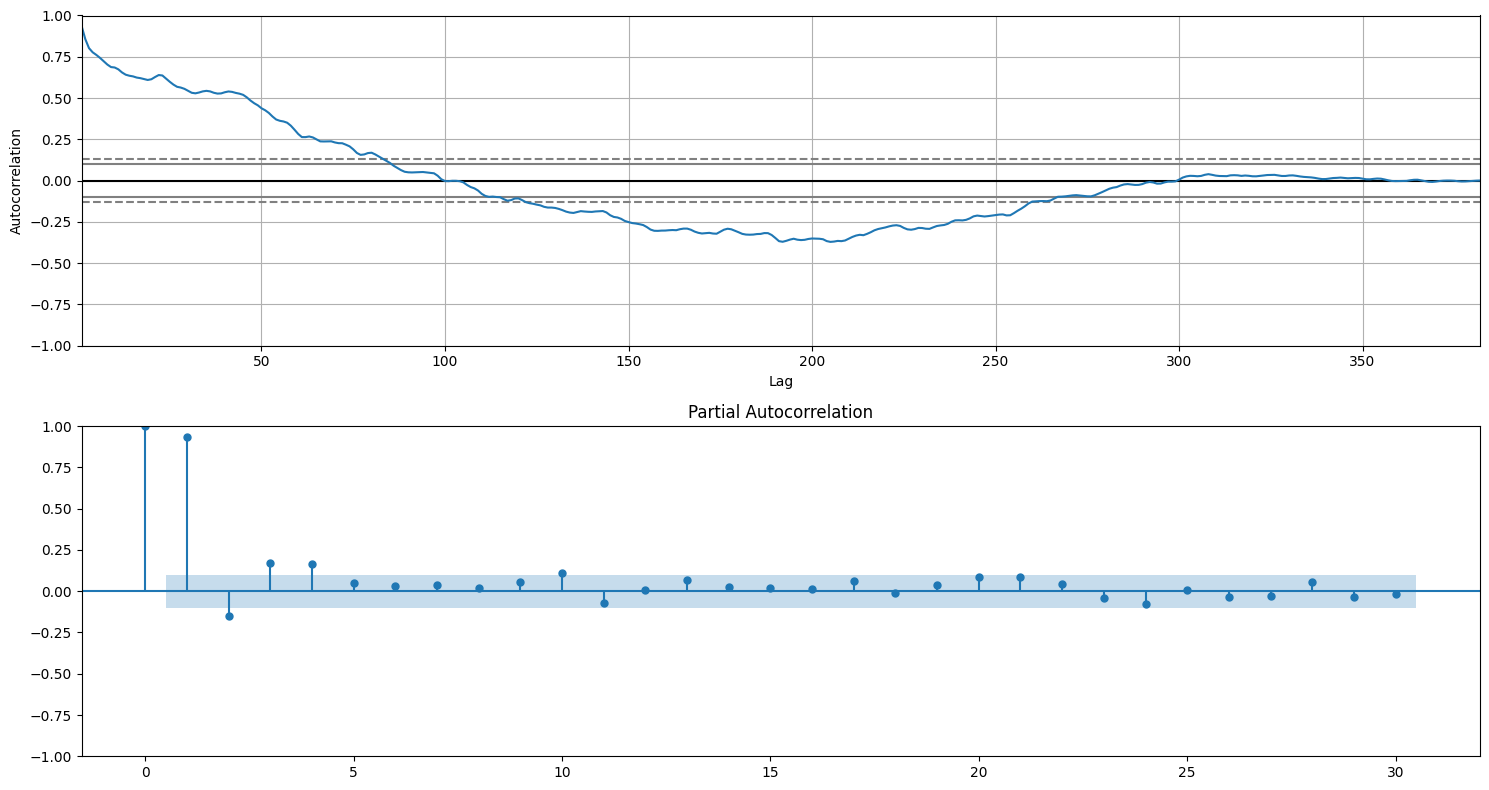

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(2,1,1)
pd.plotting.autocorrelation_plot(temp)

ax = fig.add_subplot(2,1,2)
plot_pacf(temp,ax = ax, method='ywm', lags=30)
plt.tight_layout()
plt.show()

In [46]:
print(f"Differencing order: {ndiffs(temp, test='adf')}")

Differencing order: 1


### Preprocess data


In [47]:
lags = 7
temp_lag = pd.DataFrame({'target':temp})
        
for i in range(lags):
    shift_temp = temp.shift(i+1).rename(f"lag{i+1}")
    temp_lag = pd.concat([temp_lag, shift_temp], axis=1)

temp_lag = temp_lag.dropna()

/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


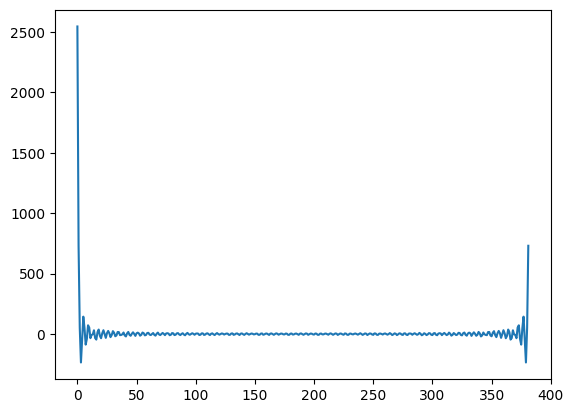

In [72]:


plt.plot(fft(temp.index.month))

### Split train test set

In [48]:
train = temp_lag[temp_lag.index <= pd.to_datetime('2024/09/15')]
test = temp_lag[temp_lag.index > pd.to_datetime('2024/09/15')]

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (350, 2)
Test: (31, 2)


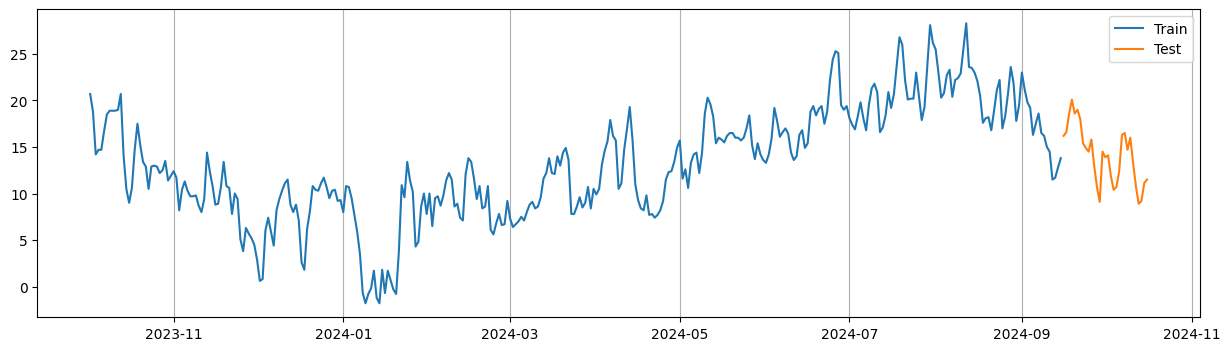

In [49]:
fig = plt.figure(figsize=(15,4))

plt.plot(train['target'], label='Train')
plt.plot(test['target'], label='Test')
plt.gca().xaxis.grid()
plt.legend()

### Normalize data

In [50]:
scaler = MinMaxScaler(feature_range=(0,1))

# train_normalized = scaler.transform(train)
# test_normalized = scaler.transform(test)

min_temp = train.min(axis=None)
max_temp = train.max(axis=None)

def min_max_scaler(x):
    return (x - min_temp) / (max_temp - min_temp)

train_normalized = train.map(min_max_scaler).values
test_normalized = test.map(min_max_scaler).values

### Prepare dataset

In [9]:
class ParisTemperatureTimeDelayEmbedding:
    def __init__(self,  dataset):
        self.dataset = dataset

    def __getitem__(self, idx: int):
        features = self.dataset[idx, 1:]
        target = self.dataset[idx, 0]

        features = torch.from_numpy(np.asarray(features)).float()
        target = torch.from_numpy(np.asarray(target)).float()
        return features, target


    def __len__(self):
        return self.dataset.shape[0]

In [52]:
train_dataset = ParisTemperatureTimeDelayEmbedding(train_normalized)
test_dataset = ParisTemperatureTimeDelayEmbedding(test_normalized)

In [53]:
train_dataset[0]

(tensor([0.6877]), tensor(0.7475))

In [54]:
batch = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

### Define model

In [4]:
class LstmOneHorizon(nn.Module):
    def __init__(self,hidden_size1 = 32, num_layers=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size = 1, hidden_size= hidden_size1, num_layers=num_layers, batch_first=True)
        self.regressor = nn.Linear(in_features=hidden_size1, out_features=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        _, (x, _) = self.lstm1(x)
        if (x.size(0) != 1):
            x = self.flatten(x)
        x = self.regressor(x)

        return x.squeeze()


In [56]:
num_layers = 1

model = LstmOneHorizon(hidden_size1=32).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

### Train

Lags: 1
----------------------------------------------------------------------------------------------------
EPOCH [1/1500]
Train loss: 0.1590888767757199, Validation loss: 0.10877528041601181
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [2/1500]
Train loss: 0.07607639907986265, Validation loss: 0.03628490213304758
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [3/1500]
Train loss: 0.032928474258038805, Validation loss: 0.009926836239174008
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [4/1500]
Train loss: 0.03024483898612247, Validation loss: 0.00801414786837995
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [5/1500]
Train loss: 0.0316836603239856, Validation loss

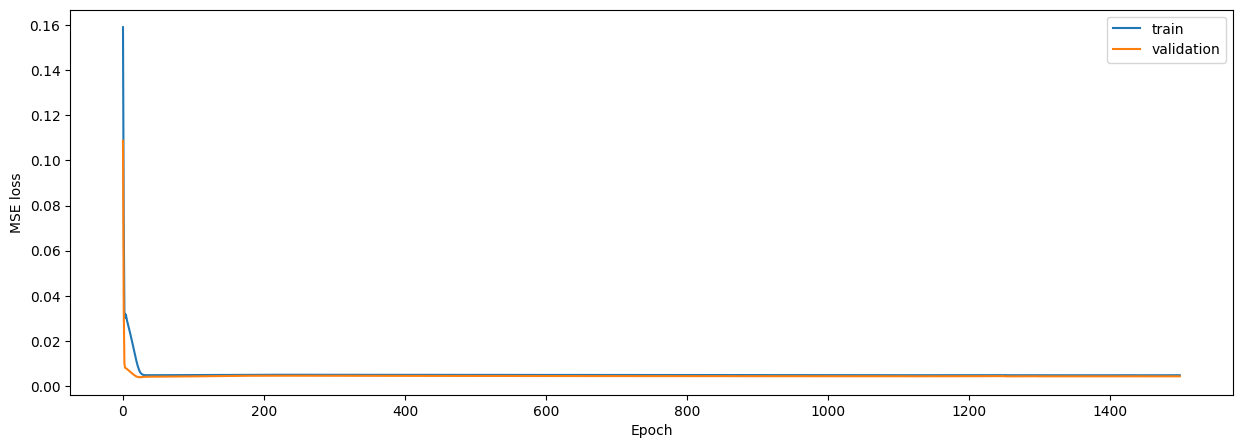

In [57]:
epochs = 1500
train_loss = []
test_loss = []
best_test_loss = 10000

print(f"Lags: {lags}")

for epoch in range(epochs):
    print('-' * 100)
    print(f'EPOCH [{epoch+1}/{epochs}]')


    model.train()
    loss_train_batch = 0 
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(features)

        # In case batch only has 1 sample, output will be of shape []
        # The below "if" is to transform shape to [1] to make it comparable with 
        # the target
        if (output.size() == torch.Size([])):
            output = output.unsqueeze(0)

        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_train_batch += loss.item()
    
    train_loss.append(loss_train_batch/len(train_dataloader))


    model.eval()
    loss_val_batch = 0
    with torch.no_grad():
        for i, (features, target) in enumerate(test_dataloader):
            features = features.to(device).unsqueeze(2)
            target = target.to(device)

            output = model(features)

            # In case batch only has 1 sample, output will be of shape []
            # The below "if" is to transform shape to [1] to make it comparable with 
            # the target
            if (output.size() == torch.Size([])):
                output = output.unsqueeze(0)
    
            vloss = loss_fn(output, target)

            loss_val_batch += vloss.item()

    test_loss.append(loss_val_batch/len(test_dataloader))
    print(f'Train loss: {loss_train_batch/len(train_dataloader)}, Validation loss: {loss_val_batch/len(test_dataloader)}')

    if (loss_val_batch < best_test_loss):
        best_test_loss = loss_val_batch
        print("New best model found")

plt.figure(figsize=(15,5))
plt.plot(np.arange(len(train_loss), dtype=int), train_loss, label='train')
plt.plot(np.arange(len(test_loss), dtype=int), test_loss, label= 'validation')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()



### Test model

In [58]:
# model = LstmOneHorizon().to(device)
# model.load_state_dict(torch.load('../model/temp_norm_lstm_ts1_b16.pth'))

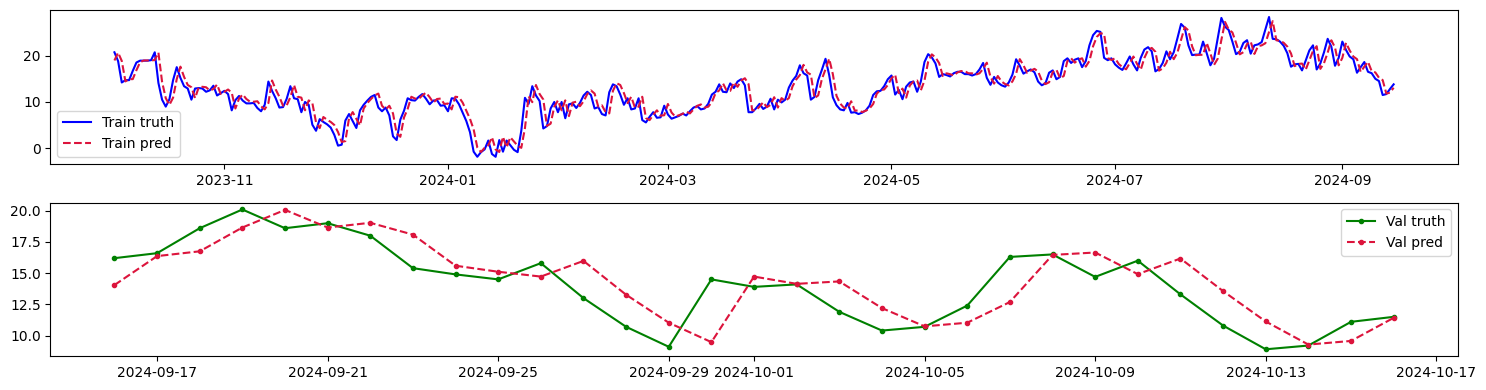

In [64]:
train_outputs = []
test_outputs = []
model.eval()
with torch.no_grad():
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = model(features)

        # In case batch only has 1 sample, output will be of shape []
        # The below "if" is to transform shape to [1] to make it comparable with 
        # the target
        if (output.size() == torch.Size([])):
            output = output.unsqueeze(0)
        output = output.cpu().tolist()

        train_outputs += output
        

    for i, (features, target) in enumerate(test_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = model(features)

        # In case batch only has 1 sample, output will be of shape []
        # The below "if" is to transform shape to [1] to make it comparable with 
        # the target
        if (output.size() == torch.Size([])):
            output = output.unsqueeze(0)

        output = output.cpu().tolist()

        test_outputs += output

train_outputs = np.array(train_outputs)
test_outputs = np.array(test_outputs)

train_outputs = train_outputs * (max_temp - min_temp) + min_temp
test_outputs = test_outputs * (max_temp - min_temp) + min_temp

train_outputs = pd.Series(np.squeeze(train_outputs), index=train.index)
test_outputs = pd.Series(np.squeeze(test_outputs), index=test.index)

fig = plt.figure(figsize=(15,4))

fig.add_subplot(2,1,1)
plt.plot(train['target'], label='Train truth', color='blue')
plt.plot(train_outputs,color='crimson', linestyle = 'dashed', label='Train pred')
plt.legend()


fig.add_subplot(2,1,2)
plt.plot(test['target'], color='green', label='Val truth', marker='.')
plt.plot(test_outputs,color = 'crimson', linestyle = 'dashed',marker='.', label='Val pred')
plt.legend()

plt.tight_layout()


In [65]:
print(f"RMSE = {root_mean_squared_error(test['target'], test_outputs)}")
print(f"R2 = {r2_score(test['target'], test_outputs)}")
print(f"MAPE = {mean_absolute_percentage_error(test['target'], test_outputs)}")

RMSE = 1.9694794910112514
R2 = 0.5932398591498862
MAPE = 0.11891641118750809


In [61]:
# torch.save(model.state_dict(), f'../model/temp_norm_Lstm_ts{lags}_b{batch}_nl{num_layers}_.pth')

### Hyperparameter tuning

In [12]:
def lag_embedding(trial, ts):
    lags = trial.suggest_int('lags', 1, 30)
    ts_lag = pd.DataFrame({'target':ts})
        
    for i in range(lags):
        shift_ts = ts.shift(i+1).rename(f"lag{i+1}")
        ts_lag = pd.concat([ts_lag, shift_ts], axis=1)

    ts_lag = ts_lag.dropna()

    return ts_lag


def split_train_test(ts, date='2024/09/15'):
    train = ts[ts.index <= pd.to_datetime(date)]
    test = ts[ts.index > pd.to_datetime(date)]

    return train, test
    
def normalize(train, test):
    min_ts = train.min(axis=None)
    max_ts = train.max(axis=None)

    def min_max_scaler(x):
        return (x - min_ts) / (max_ts - min_ts)
    

    train_normalized = train.map(lambda x: (x - min_ts)/(max_ts - min_ts)).values
    test_normalized = test.map(lambda x: (x - min_ts)/(max_ts - min_ts)).values
    
    return train_normalized, test_normalized, min_ts, max_ts

def get_dataloader(trial, train, test):
    batch = trial.suggest_int('batch_size', 8, 32)

    train_dataset = ParisTemperatureTimeDelayEmbedding(train)
    test_dataset = ParisTemperatureTimeDelayEmbedding(test)

    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
    return train_dataloader, test_dataloader

def define_model(trial):
    hidden_size1 = trial.suggest_int("hidden_size1", 32, 256)
    model = LstmOneHorizon(hidden_size1=hidden_size1)
    return model

def objective(trial):
    temp_lag = lag_embedding(trial, temp, )
    train, test = split_train_test(temp_lag)
    train_normalized, test_normalized, min, max = normalize(train, test)
    train_dataloader, test_dataloader = get_dataloader(trial, train_normalized, test_normalized)

    model = define_model(trial).to(device)
    loss_fn = nn.MSELoss()

    lr = trial.suggest_float("lr", 0.00001, 0.001, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    epochs = 1500
    train_loss = []


    for epoch in range(epochs):
        model.train()
        loss_train_batch = 0 
        for i, (features, target) in enumerate(train_dataloader):
            features = features.to(device).unsqueeze(2)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(features)

            if (output.size() == torch.Size([])):
                output = output.unsqueeze(0)

            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            loss_train_batch += loss.item()
        
        train_loss.append(loss_train_batch/len(train_dataloader))

        test_outputs = []

        with torch.no_grad():
            for i, (features, target) in enumerate(test_dataloader):
                features = features.to(device).unsqueeze(2)
                target = target.to(device)

                output = model(features)

                if (output.size() == torch.Size([])):
                    output = output.unsqueeze(0)

                output = output.cpu().tolist()

                test_outputs += output

        test_outputs = np.array(test_outputs)
        test_outputs = test_outputs * (max - min) + min
        test_outputs = pd.Series(np.squeeze(test_outputs), index=test.index)

        rmse = root_mean_squared_error(test['target'], test_outputs)
        trial.report(rmse, epoch) 

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return rmse



In [16]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-11-21 13:13:17,863] A new study created in memory with name: no-name-522fb2e3-0190-4110-a813-553e98e9c857


[W 2024-11-21 13:14:15,159] Trial 0 failed with parameters: {'lags': 21, 'batch_size': 10, 'hidden_size1': 201, 'lr': 3.0133606593991645e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_10006/285448131.py", line 80, in objective
    optimizer.step()
  File "/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/torch/optim/optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/torch/optim/optimizer.py", line 91, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/torch/optim/adam.py", line 223, in step
  

KeyboardInterrupt: 

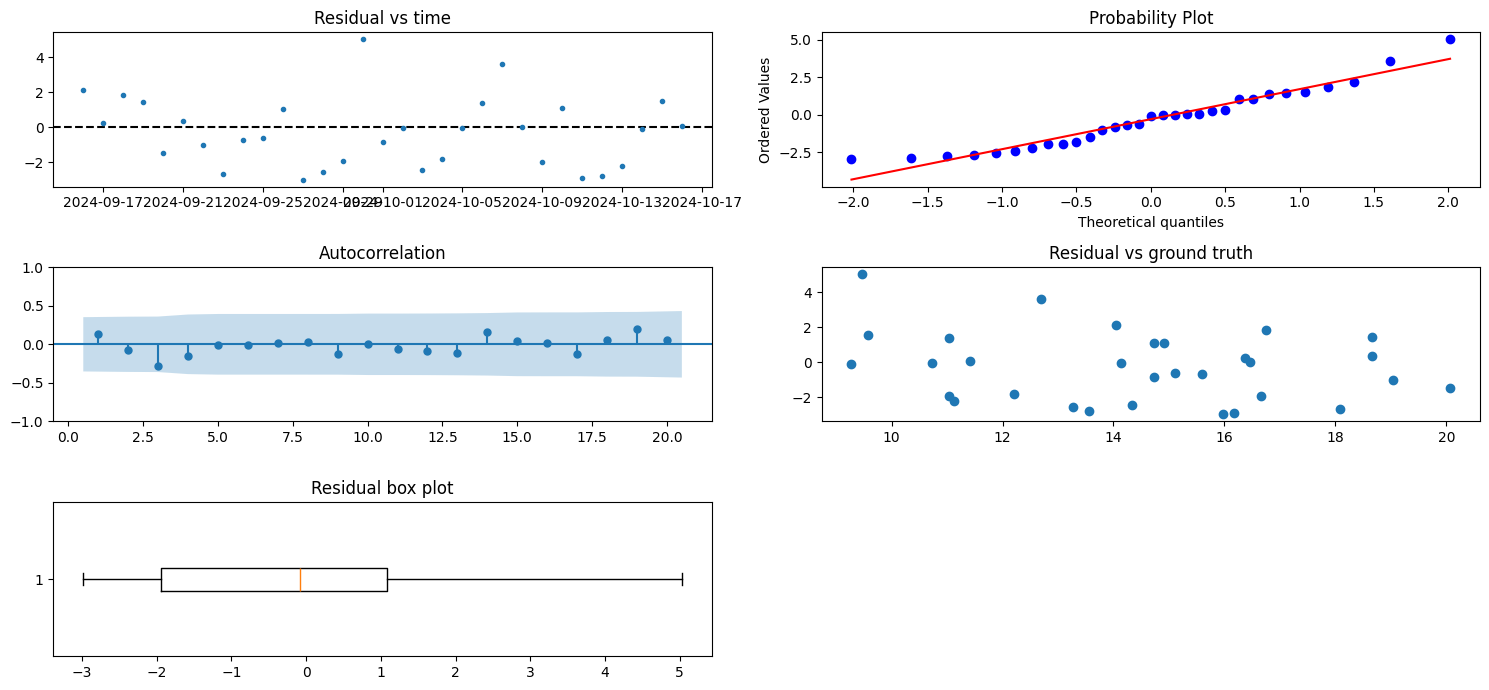

In [66]:
residuals = test['target'] - test_outputs 
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(3,2,1)
plt.axhline(0, color='k', linestyle='dashed')
plt.plot(residuals, '.')
plt.title("Residual vs time")

fig.add_subplot(3,2,2)
stats.probplot(residuals, dist="norm", plot=plt)

ax = fig.add_subplot(3,2,3)
plot_acf(residuals, lags=20, ax=ax, zero=False)

fig.add_subplot(3,2,4)
plt.scatter(test_outputs, residuals)
plt.title("Residual vs ground truth")

fig.add_subplot(3,2,5)
plt.boxplot(residuals, vert=False)
plt.title("Residual box plot")

plt.tight_layout()

In [63]:
adf_test(residuals)

ADF Statistic: -4.129822443455423
p-value: 0.0008642465068891025
Time series is stationary.
